In [2]:
# standard libs
import os
import sys
import logging

# project lib
PROJECT_SRC_PATH = os.path.join(os.path.abspath(''), '..', 'src')
sys.path.append(PROJECT_SRC_PATH)

import utils
import dataset
import visualizations
from prediction_age import AgePredictor, AgePredictorComparison
from preprocessing import *

# external libs
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely import wkt

import shap
from functools import partial

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier
from xgboost import XGBRegressor, XGBClassifier, XGBRFClassifier

/usr/local/Caskroom/miniconda/base/envs/urban-form-ml/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
%load_ext autoreload
%autoreload 2

## Data

In [5]:
path_data_france = os.path.join('..', 'data', 'france-cities-200.csv')
data_france = pd.read_csv(path_data_france)


In [6]:
path_data_netherlands = os.path.join('..', 'data', 'netherlands-cities-200.csv')
data_netherlands = pd.read_csv(path_data_netherlands)

In [379]:
data_france_sample = data_france.sample(frac=.1, random_state=dataset.GLOBAL_REPRODUCIBILITY_SEED)
data_netherlands_sample = data_netherlands.sample(frac=.1, random_state=dataset.GLOBAL_REPRODUCIBILITY_SEED)


In [138]:
xgb_params_optimal = {
    'max_depth': 10,
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'colsample_bytree': 0.5,
    'subsample': 1.0,
}

## Preprocessing

In [141]:
data_france_sample['city'].unique()
data_netherlands_sample['city'].unique()
print(len(filter_features(data_france_sample, regex='_buffer').columns))
print(len(filter_features(data_france_sample, regex='street').columns))
print(len(filter_features(data_france_sample, regex='(_buffer|street)').columns))
print(len(filter_features(data_france_sample, regex='(?=.*street)(?=.*_buffer)').columns))
print(len(filter_features(data_france_sample, regex='closeness').columns))
print(len(filter_features(data_france_sample, regex='betweenness').columns))

74
49
87
36
12
6


In [407]:
a = normalize_features_citywise(data_france_sample, selection=dataset.STREET_FEATURES_CENTRALITY)
# a[dataset.STREET_FEATURES_CENTRALITY].describe()
a.groupby('city')[dataset.STREET_FEATURES_CENTRALITY].std().describe()


,street_betweeness_global_av_within_buffer_100,street_betweeness_global_av_within_buffer_500,street_betweeness_global_closest_street,street_betweeness_global_max_within_buffer_100,street_betweeness_global_max_within_buffer_500,street_closeness_500_av_within_buffer_100,street_closeness_500_av_within_buffer_500,street_closeness_500_closest_street,street_closeness_500_max_within_buffer_100,street_closeness_500_max_within_buffer_500,street_closeness_global_closest_street
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.147375,0.155380,0.174034,0.236465,0.274345,0.220094,0.250214,0.207332,0.239861,0.267761,0.235272
std,0.033606,0.037924,0.041285,0.046581,0.046194,0.032956,0.045168,0.035100,0.038189,0.059246,0.034878
min,0.075671,0.068770,0.070115,0.121598,0.144153,0.132009,0.041862,0.033404,0.119448,0.000000,0.115096
25%,0.125278,0.128340,0.147746,0.205943,0.243582,0.198618,0.222084,0.187287,0.215841,0.242096,0.216826
50%,0.146961,0.156513,0.168148,0.233026,0.278180,0.218451,0.253954,0.208657,0.239431,0.273186,0.235986
75%,0.169252,0.174417,0.199067,0.266860,0.306004,0.240492,0.278842,0.229314,0.266626,0.311362,0.256156
max,0.257998,0.272636,0.296286,0.368938,0.385952,0.328781,0.341850,0.296390,0.357090,0.388116,0.343756


In [384]:
data_france_sample.groupby('city')[dataset.STREET_FEATURES_CENTRALITY].std().describe()

,street_betweeness_global_av_within_buffer_100,street_betweeness_global_av_within_buffer_500,street_betweeness_global_closest_street,street_betweeness_global_max_within_buffer_100,street_betweeness_global_max_within_buffer_500,street_closeness_500_av_within_buffer_100,street_closeness_500_av_within_buffer_500,street_closeness_500_closest_street,street_closeness_500_max_within_buffer_100,street_closeness_500_max_within_buffer_500,street_closeness_global_closest_street
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.147375,0.155380,0.045439,0.236465,0.274345,0.220094,0.250214,0.000035,0.239861,0.267761,0.000019
std,0.033606,0.037924,0.023123,0.046581,0.046194,0.032956,0.045168,0.000027,0.038189,0.059246,0.000010
min,0.075671,0.068770,0.017131,0.121598,0.144153,0.132009,0.041862,0.000008,0.119448,0.000000,0.000004
25%,0.125278,0.128340,0.030625,0.205943,0.243582,0.198618,0.222084,0.000019,0.215841,0.242096,0.000012
50%,0.146961,0.156513,0.040208,0.233026,0.278180,0.218451,0.253954,0.000028,0.239431,0.273186,0.000016
75%,0.169252,0.174417,0.050138,0.266860,0.306004,0.240492,0.278842,0.000039,0.266626,0.311362,0.000023
max,0.257998,0.272636,0.140798,0.368938,0.385952,0.328781,0.341850,0.000259,0.357090,0.388116,0.000061


In [402]:
# centrality_features = data_france.filter(regex='closeness|betweeness').columns
feature_std_per_city = data_france.groupby('city')[dataset.STREET_FEATURES_CENTRALITY].std()
normed_feature_variation_across_cities = feature_std_per_city.apply(lambda df: df.std() / df.mean())
most_incomparable_features = normed_feature_variation_across_cities.sort_values(ascending=False)[:5]
most_incomparable_feature_names = list(most_incomparable_features.index)


In [403]:
most_incomparable_features

street_closeness_500_closest_street              0.824529
street_closeness_global_closest_street           0.516258
street_betweeness_global_closest_street          0.493106
street_betweeness_global_av_within_buffer_500    0.268764
street_betweeness_global_av_within_buffer_100    0.242709
dtype: float64

In [ ]:
feature_std_per_city.filter(regex='Canton', axis=0)

In [450]:
data_france.groupby('city')[dataset.STREET_FEATURES_CENTRALITY].mean()['street_closeness_global_closest_street'].sort_values(ascending=False)


city
Vichy                        0.000369
Moulins                      0.000364
Montélimar  1er Canton       0.000359
Brioude                      0.000354
Le Puy-en-Velay-Sud-Ouest    0.000343
                               ...   
Rémuzat                      0.000054
Ruynes-en-Margeride          0.000054
Montpezat-sous-Bauzon        0.000053
Séderon                      0.000046
Valgorge                     0.000043
Name: street_closeness_global_closest_street, Length: 200, dtype: float64

In [406]:
fragmented_cities = flatten(get_fragmented_level_4_cities(data_boundaries))
set(fragmented_cities).intersection(feature_std_per_city['street_closeness_global_closest_street'].sort_values(ascending=False)[:10].index)

{'Brioude',
 'Crest',
 'Cusset',
 'Le Puy-en-Velay-Ouest',
 'Le Puy-en-Velay-Sud-Ouest',
 'Montluçon',
 'Moulins',
 'Oyonnax',
 'Romans-sur-Isère'}

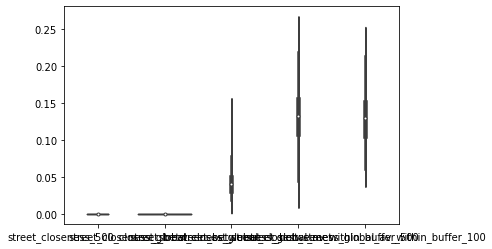

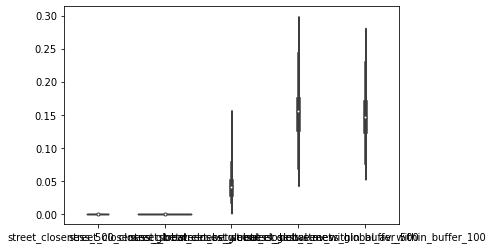

In [380]:
std_df = data_france_sample.groupby('city')[most_incomparable_feature_names].std() #.sort_values(by=['buildings_within_buffer_100'])
sns.violinplot(data=std_df.iloc[:,:10])
plt.show()

normalized_df = normalize_centrality_features_citywise(data_france_sample)
norm_std_df = normalized_df.groupby('city')[most_incomparable_feature_names].std()
sns.violinplot(data=norm_std_df.iloc[:,:10])
plt.show()


In [151]:
city_centrality_metrics_comparison = data_france_sample.groupby('city')[dataset.STREET_FEATURES_CENTRALITY].describe()
city_centrality_metrics_comparison.sort_values(by=[('street_betweeness_global_max_within_buffer_100', 'std')])

street_betweeness_global_closest_street                      \
                                                   count      mean       std   
city                                                                           
Escurolles                                        2510.0  0.011965  0.022490   
Vichy                                             1125.0  0.011980  0.020776   
Bourg-de-Péage                                    3326.0  0.007013  0.017173   
Crest-Nord                                        1195.0  0.012576  0.031976   
Treffort-Cuisiat                                   975.0  0.017247  0.030692   
...                                                  ...       ...       ...   
Die                                                700.0  0.040732  0.089967   
Bourdeaux                                          292.0  0.051607  0.072254   
Alleyras                                            69.0  0.066876  0.119443   
Valgorge                                           353.0  0.066582  0.095581   
Burzet                                             299.0  0.074857  0.140798   

                                                                    \
                       min       25%       50%       75%       max   
city                                                                 
Escurolles        0.000000  0.000483  0.002578  0.011363  0.258085   
Vichy             0.000000  0.000817  0.002440  0.013105  0.139924   
Bourg-de-Péage    0.000000  0.000270  0.000603  0.004681  0.244920   
Crest-Nord        0.000000  0.000743  0.001865  0.009491  0.305106   
Treffort-Cuisiat  0.000000  0.001112  0.003399  0.017756  0.231503   
...                    ...       ...       ...       ...       ...   
Die               0.000000  0.002242  0.003951  0.024398  0.441631   
Bourdeaux         0.000152  0.005249  0.008730  0.081344  0.274126   
Alleyras          0.000000  0.010050  0.010050  0.067509  0.483224   
Valgorge          0.000000  0.005362  0.025945  0.089928  0.337859   
Burzet            0.000000  0.003247  0.003247  0.058502  0.491052   

                 street_closeness_global_closest_street            ...  \
                                                  count      mean  ...   
city                                                               ...   
Escurolles                                       2510.0  0.000104  ...   
Vichy                                            1125.0  0.000369  ...   
Bourg-de-Péage                                   3326.0  0.000089  ...   
Crest-Nord                                       1195.0  0.000079  ...   
Treffort-Cuisiat                                  975.0  0.000084  ...   
...                                                 ...       ...  ...   
Die                                               700.0  0.000127  ...   
Bourdeaux                                         292.0  0.000106  ...   
Alleyras                                           69.0  0.000120  ...   
Valgorge                                          353.0  0.000043  ...   
Burzet                                            299.0  0.000069  ...   

                 street_betweeness_global_max_within_buffer_500       \
                                                            75%  max   
city                                                                   
Escurolles                                             0.315587  1.0   
Vichy                                                  0.343092  1.0   
Bourg-de-Péage                                         0.317164  1.0   
Crest-Nord                                             0.239130  1.0   
Treffort-Cuisiat                                       0.352587  1.0   
...                                                         ...  ...   
Die                                                    0.995040  1.0   
Bourdeaux                                              0.996573  1.0   
Alleyras                                               0.984891  1.0   
Valgorge      

## Experiments

### Visual inspection of centrality features across cities

In [6]:
data_geom = pd.read_csv(os.path.join('..', 'data', 'france-gov_geom.csv'))

In [7]:
data_boundaries = gpd.read_file(os.path.join('..', 'data', 'gadm', 'gadm36_FRA_4.shp'))

In [448]:
city = 'Brioude' #'Le Puy-en-Velay-Sud-Ouest' # 'Meximieux' #'Nantua' #'Séderon' #'Cusset' #'Ferney-Voltaire' # 'Vic-sur-Cère' #'Le Puy-en-Velay' #'Montélimar  1er Canton'
data_france_region = data_france[data_france['city'].str.contains(city)]
data_boundaries_region = data_boundaries[data_boundaries['NAME_4'].str.contains(city)]
data_geo_region = data_geom[data_geom['id'].isin(data_france_region['id'])]

# for city in ['Vic-sur-Cère', 'Ferney-Voltaire']:
#     data_france_region = data_france[data_france_sample['city'] == city]
#     data_geo_region = data_geom[data_geom['id'].isin(data_france_region['id'])]

In [441]:
data_geo_region = data_geo_region.drop_duplicates()


In [449]:
%matplotlib qt
# %matplotlib inline
# visualizations.plot_attribute_on_map(data_france_region, data_geo_region, 'street_closeness_500_max_within_buffer_500', boundaries_df=data_boundaries_region)
# visualizations.plot_attribute_on_map(data_france_region, data_geo_region, 'street_betweeness_global_closest_street', boundaries_df=data_boundaries_region)
visualizations.plot_attribute_on_map(data_france_region, data_geo_region, 'street_closeness_global_closest_street', boundaries_df=data_boundaries_region) #, vmin=0.001, vmax=0.00001)

# %matplotlib inline


### Centrality & city features predictiveness

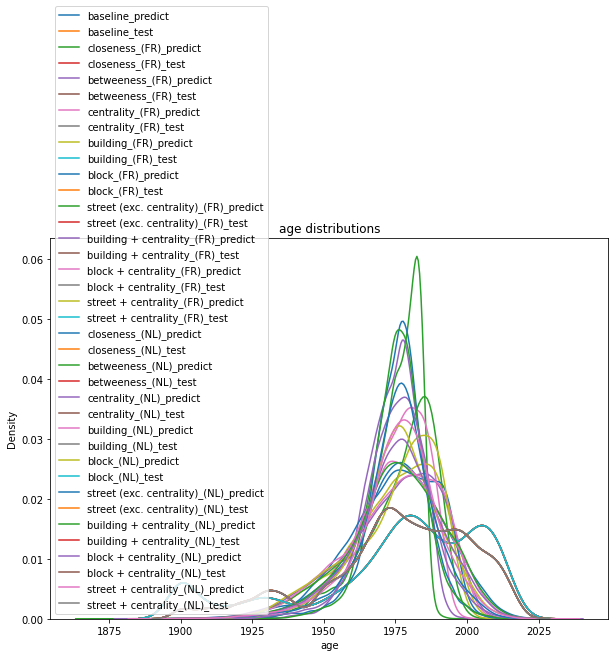

,name,R2,MAE,RMSE
2,betweeness_(FR),0.069107,23.631527,30.740719
1,closeness_(FR),0.092058,23.270261,30.359406
3,centrality_(FR),0.121059,22.815112,29.870607
11,betweeness_(NL),0.178076,17.660475,23.377787
6,street (exc. centrality)_(FR),0.178517,22.000908,28.877759
10,closeness_(NL),0.193563,17.145501,23.156488
5,block_(FR),0.196547,21.660372,28.559094
9,street + centrality_(FR),0.208180,21.582106,28.351582
8,block + centrality_(FR),0.220907,21.142298,28.122821
4,building_(FR),0.234541,21.012289,27.875649


In [323]:
logging.disable(logging.WARN)

grid_comparison_config = {
    '(FR)': {'df': data_france_sample},
    '(NL)': {'df': data_netherlands_sample},
}
comparison_config = {
    'closeness': {'preprocessing_stages': [remove_buildings_pre_1900, partial(filter_features, regex='closeness')]},
    'betweeness': {'preprocessing_stages': [remove_buildings_pre_1900, partial(filter_features, regex='betweeness')]},
    'centrality': {'preprocessing_stages': [remove_buildings_pre_1900, partial(filter_features, selection=dataset.STREET_FEATURES_CENTRALITY)]},
    'building': {'preprocessing_stages': [remove_buildings_pre_1900, partial(filter_features, selection=dataset.BUILDING_FEATURES_ALL)]},
    'block': {'preprocessing_stages': [remove_buildings_pre_1900, partial(filter_features, selection=dataset.BLOCK_FEATURES_ALL)]},
    'street (exc. centrality)': {'preprocessing_stages': [remove_buildings_pre_1900, partial(filter_features, selection=dataset.STREET_FEATURES+dataset.STREET_FEATURES_NEIGHBORHOOD)]},
    'building + centrality': {'preprocessing_stages': [remove_buildings_pre_1900, partial(filter_features, selection=dataset.STREET_FEATURES_CENTRALITY+dataset.BUILDING_FEATURES_ALL)]},
    'block + centrality': {'preprocessing_stages': [remove_buildings_pre_1900, partial(filter_features, selection=dataset.STREET_FEATURES_CENTRALITY+dataset.BLOCK_FEATURES_ALL)]},
    'street + centrality': {'preprocessing_stages': [remove_buildings_pre_1900, partial(filter_features, selection=dataset.STREET_FEATURES_ALL)]},
}

comparison = AgePredictorComparison(
    model=XGBRegressor(),
    df=data_netherlands_sample,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_buildings_pre_1900],
    comparison_config=comparison_config,
    grid_comparison_config=grid_comparison_config,
)
comparison.evaluate_comparison()

### Impact of normalizing centrality & city features on city level

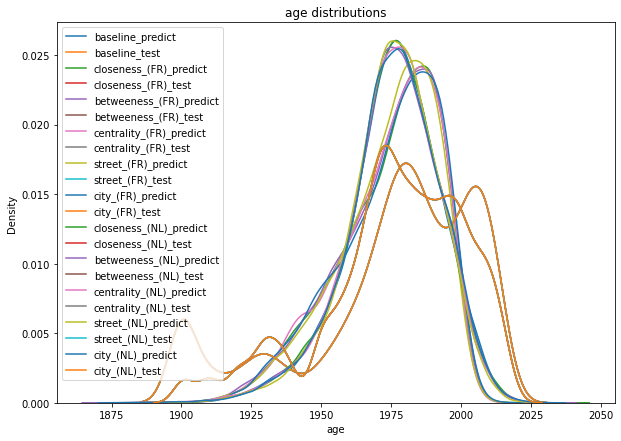

,name,R2,MAE,RMSE
4,street_(FR),0.263584,20.582849,27.341711
5,city_(FR),0.283825,20.246721,26.963338
2,betweeness_(FR),0.284140,20.293632,26.957410
1,closeness_(FR),0.286030,20.208665,26.921807
3,centrality_(FR),0.286975,20.276387,26.903973
9,street_(NL),0.399494,14.151187,19.982336
8,centrality_(NL),0.421447,13.713170,19.613678
10,city_(NL),0.424794,13.663317,19.556875
0,baseline,0.428695,13.607169,19.490440
7,betweeness_(NL),0.428812,13.646303,19.488435


In [232]:
logging.disable(logging.WARN)

grid_comparison_config = {
    '(FR)': {'df': data_france_sample},
    '(NL)': {'df': data_netherlands_sample},
}
comparison_config = {
    'closeness': {'preprocessing_stages': [remove_buildings_pre_1900, partial(normalize_features_citywise, regex='closeness')]},
    'betweeness': {'preprocessing_stages': [remove_buildings_pre_1900, partial(normalize_features_citywise, regex='betweeness')]},
    'centrality': {'preprocessing_stages': [remove_buildings_pre_1900, partial(normalize_features_citywise, selection=dataset.STREET_FEATURES_CENTRALITY)]},
    'street': {'preprocessing_stages': [remove_buildings_pre_1900, partial(normalize_features_citywise, selection=dataset.STREET_FEATURES_ALL)]},
    'city': {'preprocessing_stages': [remove_buildings_pre_1900, partial(normalize_features_citywise, selection=dataset.CITY_FEATURES)]},
}

comparison_normalization = AgePredictorComparison(
    model=XGBRegressor(),
    df=data_netherlands_sample,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_buildings_pre_1900],
    comparison_config=comparison_config,
    grid_comparison_config=grid_comparison_config,
)
comparison_normalization.evaluate_comparison()

### Fragmented cities

#### Determining fragmented cities semi-automatically

In [ ]:
regex_to_be_tested = "(.*?)(-| +\der? +\(?)(Sud|Est|Ouest|Nord|Canton)(-|\)| |$)"
test_non_matching = [
    'Aix-les-Bains', # straight-forward
    'Aix-les-Bains-Grésy', # straight-forward
    'Saint-Trivier-de-Courtes', # straight-forward
    'Saint-Estève', # cardinal direction included in city name, i.e. ESTève
]
test_machting = [
    'Ajaccio  7e Canton', # canton & double whitespace
    'Aix-en-Provence-Sud', # dash
    'Saint-Étienne-Nord-Ouest-1', # dash with multiple cardinal directions
    'Amiens 3e (Nord-Est)', # paranthesis
    'Amiens 1er (Ouest)', # 1er
    'Montluçon-Sud (3e Canton)', # cardinal directions & canton
    'Aix-les-Bains-Nord-Grésy',
]

assert all(re.match(regex_to_be_tested, city) for city in test_machting)
assert not any(re.match(regex_to_be_tested, city) for city in test_non_matching)

In [322]:
import re
from collections import defaultdict
import itertools

# finds all cities which include Sud, Est, Ouest, Nord or Canton syllabus and groups them based on their basename (also includes the city with just the basename if existing)
def get_fragmented_level_4_cities(data_gadm_boundaries):
    fragmented_city_candidates = defaultdict(list)
    for city in data_gadm_boundaries['NAME_4'].unique():
        match = re.match("(.*?)(-| +\der? +\(?)(Sud|Est|Ouest|Nord|Canton)(-|\)| |$)", city)
        if match is not None:
            fragmented_city_candidates[match.group(1)].append(match.string)


    # validate fragmented city candidates are in same region
    fragmented_city_candidates_clustered_by_region = []
    for k, v in fragmented_city_candidates.items():
        fragmented_city_candidates_clustered_by_region.extend(data_gadm_boundaries[data_gadm_boundaries['NAME_4'].isin([k]+v)].groupby('NAME_3')['NAME_4'].apply(list).values)
    fragmented_cities = [c for c in fragmented_city_candidates_clustered_by_region if len(c) > 1]

    return fragmented_cities

def flatten(lst):
    return list(itertools.chain(*lst))

#### Known issues and accepted errors

In [328]:
# Fragmented level 3 regions (i.e. Paris & Thionville)
matches = [re.match("(.*?)(-| +\der? +\(?)(Sud|Est|Ouest|Nord|Canton)", city) for city in data_boundaries['NAME_3'].unique()]
print('\nThionville level 3 regions :')
print({m.string for m in matches if m is not None})

print('\nThionville level 4 regions :')
print(sorted(list(data_boundaries[data_boundaries['NAME_3'].str.contains('Thionville')]['NAME_4'].unique())))
print('\nParis level 3 regions :')
print(sorted(list(data_boundaries[data_boundaries['NAME_3'].str.contains('Paris')]['NAME_3'].unique())))

# using .str.contains misses cities with 'basename' and doesn't validate if cities are the same level 3 region
fragmented_cities = flatten(get_fragmented_level_4_cities(data_boundaries))
print('\nCities missed:')
print(set(data_france[data_france['city'].isin(fragmented_cities)]['city'].unique()) - set(data_france[data_france['city'].str.contains('-Nord|-Sud|-Est|-Ouest|Canton')]['city'].unique()))

# Accepted errors:
# * Matching only cities if base name (after cutting Nord, eat, canton etc.) is the same (e.g. Domérat-Montluçon-Nord-Ouest will not be merged with Montluçon, Montluçon-Est (4e Canton), …; otherwise it would be impossible to differentiate which ‘Saint’ cities belong together and which do not)
# * Does not match cities if cardinal directions are in the middle of the city name, e.g. Aix-les-Bains-Grésy is not matched with Aix-les-Bains-Nord-Grésy


Thionville level 3 regions :
{'Thionville-Ouest', 'Thionville-Est'}

Thionville level 4 regions :
['Algrange', 'Cattenom', 'Fameck', 'Florange', 'Fontoy', 'Hayange', 'Metzervisse', 'Moyeuvre-Grande', 'Sierck-les-Bains', 'Thionville', 'Yutz']

Paris level 3 regions :
['Paris, 11e arrondissement', 'Paris, 12e arrondissement', 'Paris, 12e arronissement', 'Paris, 13e arrondissement', 'Paris, 14e arrondissement', 'Paris, 15e arrondissement', 'Paris, 16e arrondissement', 'Paris, 17e arrondissement', 'Paris, 18e arrondissement', 'Paris, 19e arrondissement', 'Paris, 1er arrondissement', 'Paris, 20e arrondissement', 'Paris, 2e arrondissement', 'Paris, 3e arrondissement', 'Paris, 4e arrondissement', 'Paris, 5e arrondissement', 'Paris, 6e arrondissement', 'Paris, 7e arrondissement', 'Paris, 8e arrondissement', 'Paris, 9e arrondissement']

Cities missed:
{'Romans-sur-Isère', 'Cusset', 'Moulins', 'Montélimar', 'Brioude', 'Saint-Flour', 'Montluçon', 'Aurillac', 'Oyonnax', 'Le Puy-en-Velay', 'Crest'

#### Assessing impact of fragmentation on prediction performance

In [346]:
fragmented_cities = flatten(get_fragmented_level_4_cities(data_boundaries))
data_france_fragmented = data_france[data_france['city'].isin(fragmented_cities)]
data_france_not_fragmented = data_france.drop(data_france_fragmented.index).sample(frac=len(data_france_fragmented)/(len(data_france)-len(data_france_fragmented)), random_state=dataset.GLOBAL_REPRODUCIBILITY_SEED)
data_france_baseline = pd.concat([data_france_not_fragmented, data_france_fragmented], ignore_index=False).sample(frac=len(data_france_fragmented)/(len(data_france_fragmented)+len(data_france_not_fragmented)), random_state=dataset.GLOBAL_REPRODUCIBILITY_SEED)
assert len(data_france_baseline) == len(data_france_not_fragmented) == len(data_france_fragmented)


In [347]:
logging.disable(logging.WARN)

grid_comparison_config = {
    '(fragmented)': {'df': data_france_fragmented},
    '(not-fragmented)': {'df': data_france_not_fragmented},
}
comparison_config = {
    'all': {'preprocessing_stages': [remove_buildings_pre_1900]},
    'centrality': {'preprocessing_stages': [remove_buildings_pre_1900, partial(filter_features, selection=dataset.STREET_FEATURES_CENTRALITY)]},
    'street': {'preprocessing_stages': [remove_buildings_pre_1900, partial(filter_features, selection=dataset.STREET_FEATURES_ALL)]},
    'city': {'preprocessing_stages': [remove_buildings_pre_1900, partial(filter_features, selection=dataset.CITY_FEATURES)]},
    'street + city': {'preprocessing_stages': [remove_buildings_pre_1900, partial(filter_features, selection=dataset.STREET_FEATURES_ALL+dataset.CITY_FEATURES)]},
}

comparison_city_fragmentation = AgePredictorComparison(
    model=XGBRegressor(),
    df=data_france_baseline,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_buildings_pre_1900],
    comparison_config=comparison_config,
    grid_comparison_config=grid_comparison_config,
    compare_feature_importance=True,
)
comparison_city_fragmentation.evaluate_comparison()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


,name,R2,MAE,RMSE
9,city_(not-fragmented),0.089496,23.672685,30.793806
4,city_(fragmented),0.127851,22.287586,28.954900
7,centrality_(not-fragmented),0.134655,22.760658,30.020430
8,street_(not-fragmented),0.217446,21.704755,28.548242
10,street + city_(not-fragmented),0.243283,21.245508,28.073008
6,all_(not-fragmented),0.302979,20.105794,26.942955
2,centrality_(fragmented),0.310422,19.080054,25.746519
0,baseline,0.358670,18.575924,25.154236
3,street_(fragmented),0.364910,18.235416,24.708382
5,street + city_(fragmented),0.374913,17.997716,24.513024


In [349]:
%matplotlib inline

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


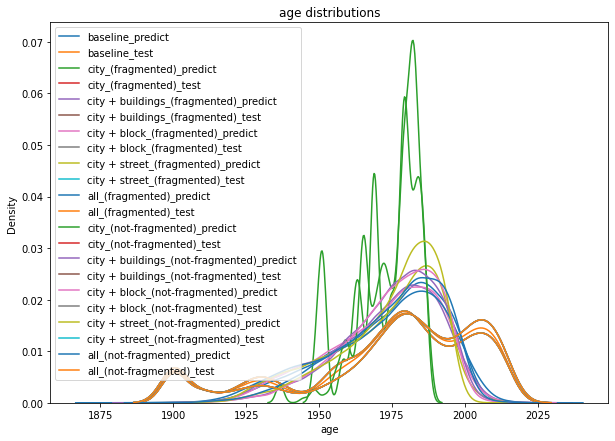

,name,R2,MAE,RMSE
6,city_(not-fragmented),0.089496,23.672685,30.793806
1,city_(fragmented),0.127851,22.287586,28.954900
9,city + street_(not-fragmented),0.243283,21.245508,28.073008
7,city + buildings_(not-fragmented),0.250961,20.873542,27.930224
8,city + block_(not-fragmented),0.257644,20.903757,27.805346
10,all_(not-fragmented),0.302979,20.105794,26.942955
0,baseline,0.358670,18.575924,25.154236
3,city + block_(fragmented),0.369046,18.118808,24.627810
4,city + street_(fragmented),0.374960,17.997287,24.512116
2,city + buildings_(fragmented),0.374997,17.837078,24.511382


In [350]:
logging.disable(logging.WARN)

grid_comparison_config = {
    '(fragmented)': {'df': data_france_fragmented},
    '(not-fragmented)': {'df': data_france_not_fragmented},
}
comparison_config = {
    'city': {'preprocessing_stages': [remove_buildings_pre_1900, partial(filter_features, selection=dataset.CITY_FEATURES)]},
    'city + buildings': {'preprocessing_stages': [remove_buildings_pre_1900, partial(filter_features, selection=dataset.CITY_FEATURES+dataset.BUILDING_FEATURES_ALL)]},
    'city + block': {'preprocessing_stages': [remove_buildings_pre_1900, partial(filter_features, selection=dataset.CITY_FEATURES+dataset.BLOCK_FEATURES_ALL)]},
    'city + street': {'preprocessing_stages': [remove_buildings_pre_1900, partial(filter_features, selection=dataset.CITY_FEATURES+dataset.STREET_FEATURES_ALL)]},
    'all': {'preprocessing_stages': [remove_buildings_pre_1900]},
}

comparison_city_fragmentation = AgePredictorComparison(
    model=XGBRegressor(),
    df=data_france_baseline,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_buildings_pre_1900],
    comparison_config=comparison_config,
    grid_comparison_config=grid_comparison_config,
    compare_feature_importance=True,
)
comparison_city_fragmentation.evaluate_comparison()

In [351]:
# baseline_importance_df = comparison_city_fragmentation.evaluate_feature_importance().loc[dataset.STREET_FEATURES_CENTRALITY].sort_values(by='var', ascending=False)
baseline_importance_df = comparison_city_fragmentation.evaluate_feature_importance(normalize_by_number_of_features=True)
baseline_importance_df['agg'] = baseline_importance_df['agg_diff_(not-fragmented)'] - baseline_importance_df['agg_diff_(fragmented)']
baseline_importance_df.sort_values(by='agg', ascending=False)[['agg']]


,agg
feature,
distance_to_closest_street,5.735257
blocks_2_to_4,5.537307
lat,5.293649
blocks_5_to_9,5.006965
av_length_street_city,4.645441
...,...
av_building_footprint_city,-2.932404
av_area_block_city,-4.734785
buildings_within_buffer_500,-4.839515


In [352]:
# baseline_importance_df = comparison_city_fragmentation.evaluate_feature_importance().loc[dataset.STREET_FEATURES_CENTRALITY].sort_values(by='var', ascending=False)
baseline_importance_df = comparison_city_fragmentation.evaluate_feature_importance(normalize_by_number_of_features=False)
baseline_importance_df['agg'] = baseline_importance_df['agg_diff_(not-fragmented)'] - baseline_importance_df['agg_diff_(fragmented)']
baseline_importance_df.sort_values(by='agg', ascending=False)[['agg']]


,agg
feature,
blocks_2_to_4,0.192139
intersections_count,0.169499
av_length_street_city,0.156187
blocks_5_to_9,0.117847
n_detached_buildings,0.086178
...,...
buildings_within_buffer_500,-0.072162
av_building_footprint_city,-0.098423
street_closeness_global_closest_street,-0.101356
